In [69]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [70]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zeina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [71]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zeina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
#importing data
df=pd.read_csv('spam_ham_dataset.csv')


In [73]:
df.head()

,# sent emails,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


# **Data Cleaning**

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   # sent emails   5171 non-null   int64 
 1   label           5171 non-null   object
 2   text            5171 non-null   object
 3   label_num       5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [75]:
df = df.drop('# sent emails ', axis=1)
df = df.drop('label', axis=1)

In [76]:
df.duplicated().sum()

178

In [77]:
df=df.drop_duplicates()
df.duplicated().sum()

0

In [78]:
#missing values
df.isnull().sum()

text         0
label_num    0
dtype: int64

In [79]:
df['label_num']=df['label_num'].astype(int)

In [80]:
# Change column name
df = df.rename(columns={"label_num": "Is_Spam"})

In [81]:
df.head()


,text,Is_Spam
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


# **Data Exploring**

In [82]:
df.shape

(4993, 2)

In [83]:
df['Is_Spam'].value_counts()

Is_Spam
0    3531
1    1462
Name: count, dtype: int64

C:\Users\zeina\AppData\Local\Temp\ipykernel_8176\1886045474.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Is_Spam', data=df, palette=colors)


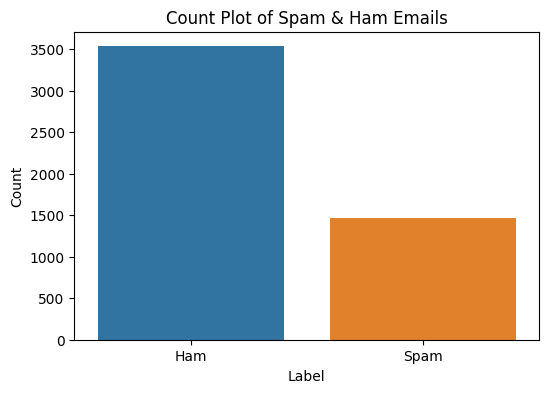

In [84]:

colors = ["#1f77b4", "#ff7f0e"]  # Blue for label 0, orange for label 1

plt.figure(figsize=(6, 4))
sns.countplot(x='Is_Spam', data=df, palette=colors)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count Plot of Spam & Ham Emails')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

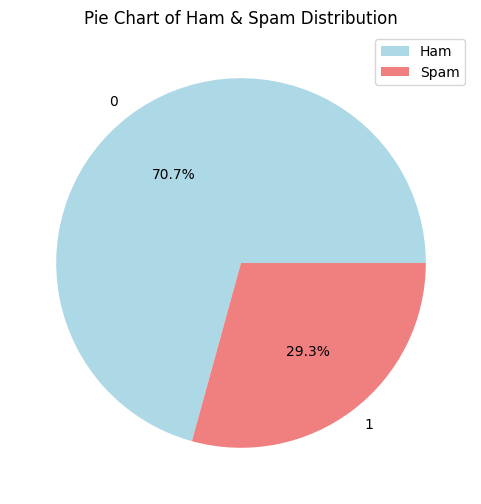

In [85]:
plt.figure(figsize=(6, 6))
df['Is_Spam'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Pie Chart of Ham & Spam Distribution')
plt.ylabel('')
plt.legend(['Ham', 'Spam'], loc='upper right')
plt.show()

In [86]:
from wordcloud import WordCloud

# Generate word clouds for spam and ham emails
spam_text = ' '.join(df[df['Is_Spam'] == 1]['text'])
ham_text = ' '.join(df[df['Is_Spam'] == 0]['text'])

spam_wordcloud = WordCloud(width=800, height=500,background_color='white').generate(spam_text)
ham_wordcloud = WordCloud(width=1000, height=600,background_color='white').generate(ham_text)



(-0.5, 799.5, 499.5, -0.5)

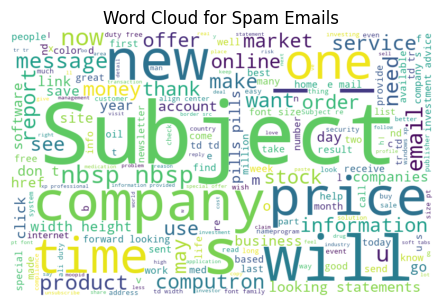

In [87]:

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Emails')
plt.axis('off')

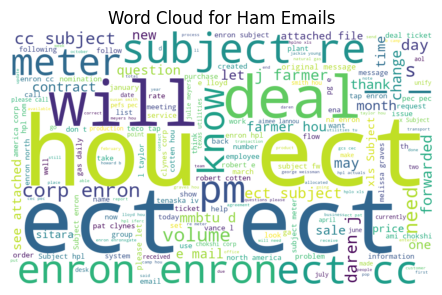

In [88]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Emails')
plt.axis('off')

plt.show()

In [89]:
 ps = PorterStemmer()

In [90]:
def transform_text(text):
    text = text.lower() # converts all characters in the text to lowercase
    text = nltk.word_tokenize(text) #tokenizes the text into individual words.

    y = []
    for i in text:
        if i.isalpha():
            y.append(i)
#If the word contains only letters and no punctuation append to list y

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()


    for i in text:
        y.append(ps.stem(i))
        #reduces words to their root or base form by removing suffixes.


    return " ".join(y)

In [91]:
df['transformed_text']=df['text'].apply(transform_text)


In [92]:
from collections import Counter
punctuation = string.punctuation
# Tokenize the text
spam_tokens = ' '.join(df[df['Is_Spam'] == 1]['transformed_text']).translate(str.maketrans('', '', punctuation)).split()
ham_tokens = ' '.join(df[df['Is_Spam'] == 0]['transformed_text']).translate(str.maketrans('', '', punctuation)).split()

# Calculate word frequencies
spam_word_freq = Counter(spam_tokens)
ham_word_freq = Counter(ham_tokens)

# Get the top N most common words
top_n = 30
top_spam_words = dict(spam_word_freq.most_common(top_n))
top_ham_words = dict(ham_word_freq.most_common(top_n))



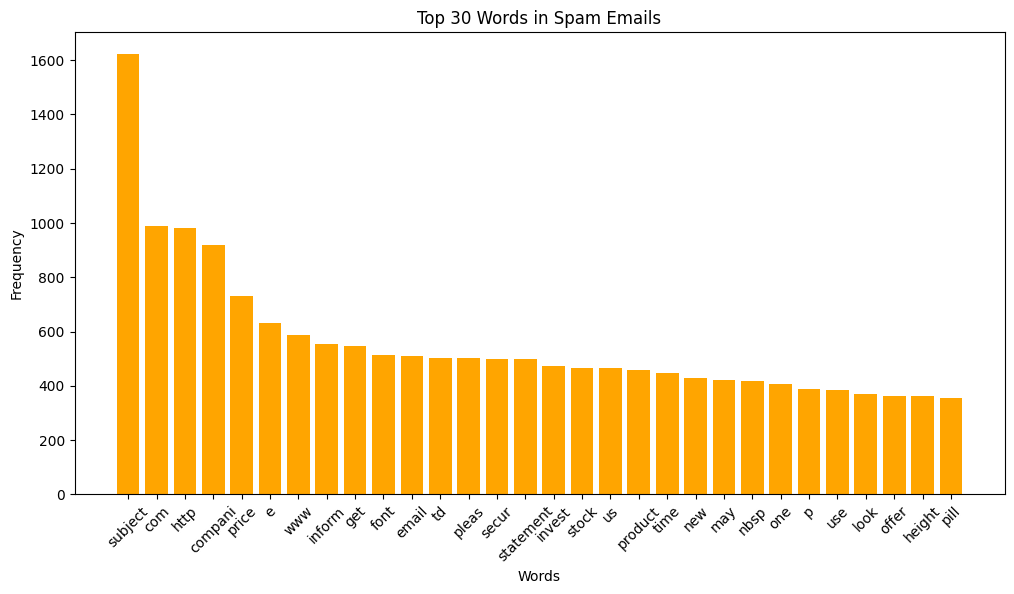

In [93]:
# Plot top N words for spam emails
plt.figure(figsize=(12, 6))
plt.bar(top_spam_words.keys(), top_spam_words.values(), color='orange')
plt.title('Top {} Words in Spam Emails'.format(top_n))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

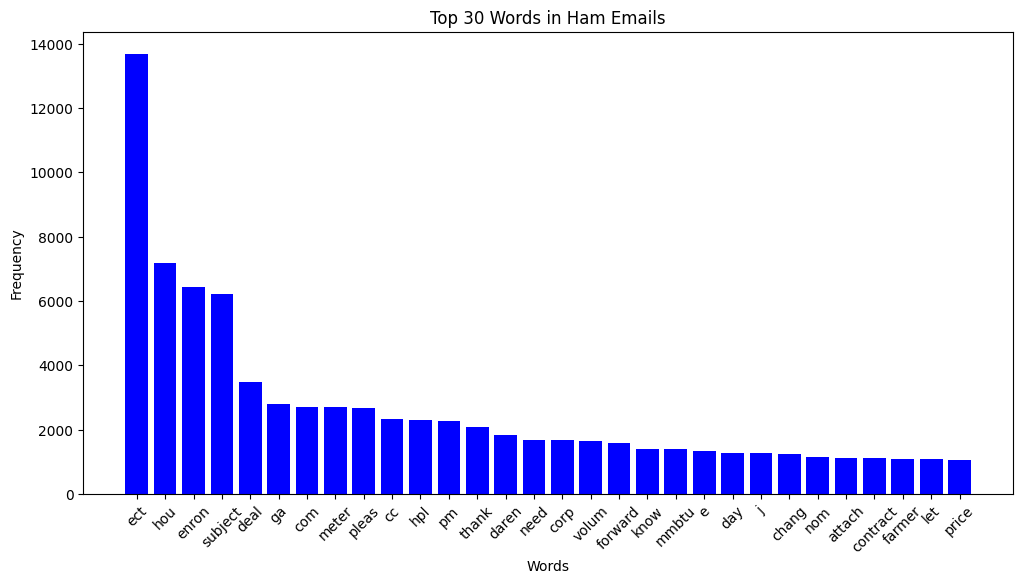

In [94]:


# Plot top N words for ham emails
plt.figure(figsize=(12, 6))
plt.bar(top_ham_words.keys(), top_ham_words.values(), color='blue')
plt.title('Top {} Words in Ham Emails'.format(top_n))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [95]:
df.describe()

,Is_Spam
count,4993.000000
mean,0.292810
std,0.455098
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# **Splitting Data**

In [96]:
x = df['transformed_text']
y = df['Is_Spam']

In [97]:
X_train , X_test,y_train,y_test= train_test_split(x, y, test_size=0.25,random_state=3)

# **Tf IDF**

In [98]:
TF=TfidfVectorizer(min_df=1,stop_words='english')
X_train_tfidf=TF.fit_transform(X_train)
X_test_tfidf=TF.transform(X_test)
y_train=y_train.astype('int')
y_test=y_test.astype('int')


# **Naive Bayes**

In [99]:
#training model
MB=MultinomialNB()
MB.fit(X_train_tfidf,y_train)

MultinomialNB()

In [100]:
y_pred_train=MB.predict(X_train_tfidf)


In [101]:
acc_train=accuracy_score(y_train,y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)

print("Accuracy of training:", acc_train)
print("Precision:", precision)
print("Recall:", recall)

Accuracy of training: 0.9610042735042735
Precision: 0.9958376690946931
Recall: 0.8707916287534122


In [102]:
y_pred_test = MB.predict(X_test_tfidf)

In [103]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.923138510808647
Precision: 0.9962825278810409
Recall: 0.7382920110192838


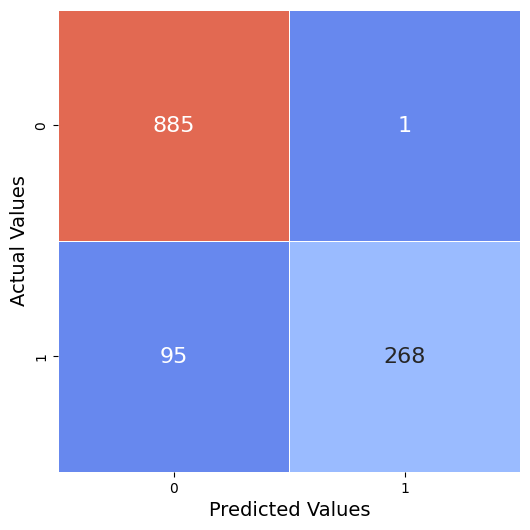

In [104]:

conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 6))
cmap = sns.color_palette("coolwarm")  # Example: using the 'Blues' colormap
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidth=0.5, square=True, cbar=False, annot_kws={"size": 16}, cmap=cmap)
plt.ylabel('Actual Values', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)
plt.show()


# **Logistic Regression**

In [105]:
lr =LogisticRegression()
lr.fit(X_train_tfidf,y_train)

LogisticRegression()

In [106]:
y_pred_train=lr.predict(X_train_tfidf)

In [107]:
acc_train=accuracy_score(y_train,y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)

print("Accuracy of training:", acc_train)
print("Precision:", precision)
print("Recall:", recall)

Accuracy of training: 0.9959935897435898
Precision: 0.9865350089766607
Recall: 1.0


In [108]:
y_pred_test = lr.predict(X_test_tfidf)


In [109]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9823859087269816
Precision: 0.962059620596206
Recall: 0.977961432506887


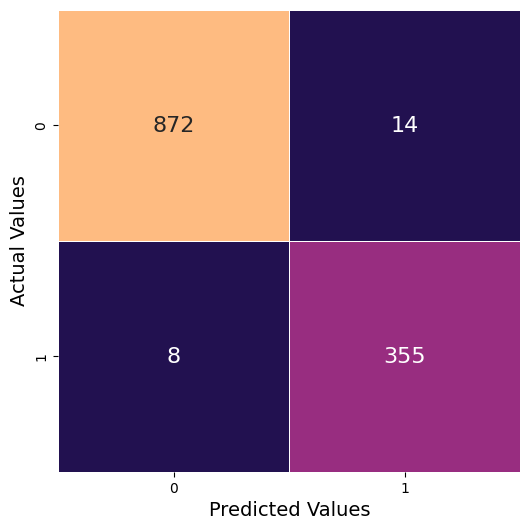

In [110]:

conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 6))
cmap = sns.color_palette("magma")  # Example: using the 'Blues' colormap
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidth=0.5, square=True, cbar=False, annot_kws={"size": 16}, cmap=cmap)
plt.ylabel('Actual Values', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)
plt.show()


# **SVM**

In [112]:
# Initialize the SVM classifier
sv = SVC(kernel='linear')
sv.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [113]:
y_pred_train=sv.predict(X_train_tfidf)

In [114]:
acc_train=accuracy_score(y_train,y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)

print("Accuracy of training:", acc_train)
print("Precision:", precision)
print("Recall:", recall)

Accuracy of training: 0.999198717948718
Precision: 0.9972776769509982
Recall: 1.0


In [115]:
y_pred_test = sv.predict(X_test_tfidf)

In [116]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9879903923138511
Precision: 0.9754098360655737
Recall: 0.9834710743801653


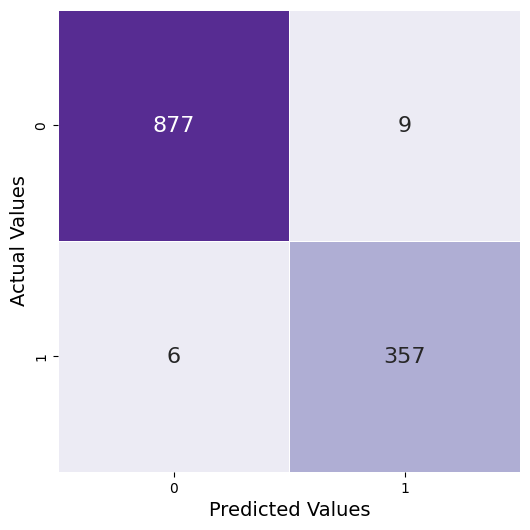

In [117]:

conf_matrix = confusion_matrix(y_test, y_pred_test)


# Plot confusion matrix with the 'Pinks' palette
plt.figure(figsize=(6, 6))
cmap = sns.color_palette("Purples")  # Using the 'Pinks' palette
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidth=0.5, square=True, cbar=False, annot_kws={"size": 16}, cmap=cmap)
plt.ylabel('Actual Values', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)
plt.show()

# **Desicion Tree**

In [118]:
DT = DecisionTreeClassifier(random_state = 13)
DT.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(random_state=13)

In [119]:
y_pred_train=DT.predict(X_train_tfidf)


In [120]:
acc_train=accuracy_score(y_train,y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)

print("Accuracy of training:", acc_train)
print("Precision:", precision)
print("Recall:", recall)

Accuracy of training: 1.0
Precision: 1.0
Recall: 1.0


In [121]:
y_pred_test = DT.predict(X_test_tfidf)


In [122]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9319455564451561
Precision: 0.8818681318681318
Recall: 0.8842975206611571


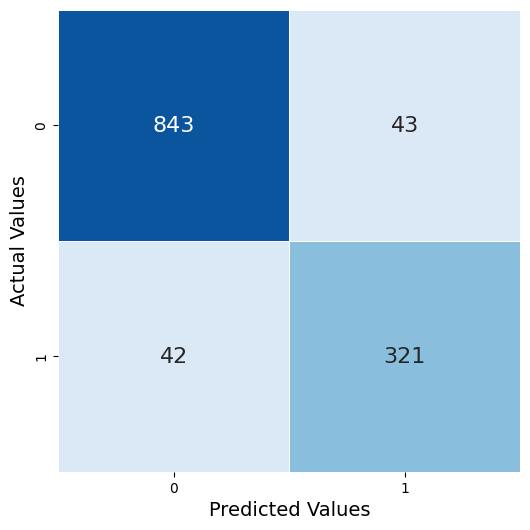

In [123]:
conf_matrix = confusion_matrix(y_test, y_pred_test)


# Plot confusion matrix with the 'Pinks' palette
plt.figure(figsize=(6, 6))
cmap = sns.color_palette("Blues")  # Using the 'Pinks' palette
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidth=0.5, square=True, cbar=False, annot_kws={"size": 16}, cmap=cmap)
plt.ylabel('Actual Values', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)
plt.show()

# **KNN**

In [124]:
KN = KNeighborsClassifier (n_neighbors=5)

In [125]:
KN.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [126]:
y_pred_train=KN.predict(X_train_tfidf)

In [128]:
acc_train=accuracy_score(y_train,y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)

print("Accuracy of training:", acc_train)
print("Precision:", precision)
print("Recall:", recall)

Accuracy of training: 0.9759615384615384
Precision: 0.9921951219512195
Recall: 0.9253867151956324


In [129]:
y_pred_test = KN.predict(X_test_tfidf)

In [130]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9615692554043235
Precision: 0.981651376146789
Recall: 0.8842975206611571


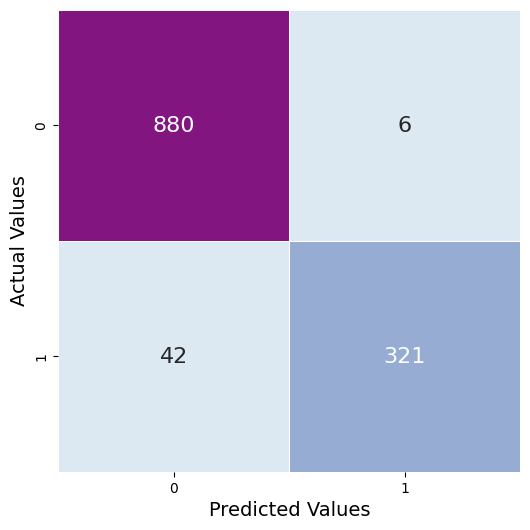

In [131]:
conf_matrix = confusion_matrix(y_test, y_pred_test)


# Plot confusion matrix with the 'Pinks' palette
plt.figure(figsize=(6, 6))
cmap = sns.color_palette("BuPu")  # Using the 'Pinks' palette
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidth=0.5, square=True, cbar=False, annot_kws={"size": 16}, cmap=cmap)
plt.ylabel('Actual Values', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)
plt.show()

# **Linking Deployment**

In [ ]:
#import pickle
# Save model object to a file & run it in notebook
#pickle.dump(DT, open('Spam_classification_final', 'wb'))
#loaded_model = pickle.load(open('Spam_classification_final', 'rb'))

In [132]:
import pickle
# Define the dictionary containing the trained models
models = {
    "Logistic Regression": lr,
    "Naive Bayes": MB,
    "Decision Tree": DT,
    "SVM": sv,
    "KNN": KN
}
# Save model object to a file & run it in notebook
# Save the dictionary containing the models to a file
with open('Spam_classification_final_project.pkl', 'wb') as f:
    pickle.dump(models, f)
#pickle.dump(LR, open('Spam_classification_final_project', 'wb'))
#loaded_model = pickle.load(open('Spam_classification_final', 'rb'))

In [133]:
pickle.dump(TF,open('vectorizer.pkl','wb'))